In [1]:
# Import from standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import time
import random

# Import functions from file
from algorithms import *
from functions import *

# Fake Dataset

Data Generation

In [2]:
# Class 1 distribution
mean_1 = [0, 0]
cov_1 = [[1, 0],
         [0, 1]]
n_1 = 100
X_1 = np.random.multivariate_normal(mean_1, cov_1, n_1)

# Class 2 distribution
mean_2 = [2, 3]
cov_2 = [[1/2, 1/4], 
         [1/4, 3/2]]
n_2 = 100 
X_2 = np.random.multivariate_normal(mean_2, cov_2, n_2)

N = n_1+n_2 # Total number of observations
X = np.concatenate((X_1 ,X_2),axis=0) # Observations coordinates
y = np.concatenate( (np.ones([n_1,1]),-np.ones([n_2,1]) ),axis=0 ) # Obeservations labels

In [3]:
# Split dataset into labeled and unlabeled data
known_rate = 0.5
known_variables = int(known_rate*N)
known_index = np.random.choice(N, known_variables, replace=False)
unknown_index = [n for n in range(N) if n not in known_index]
X_labeled = X[known_index,:]
X_unlabeled = X[unknown_index,:]
y_labeled = y[known_index]
y_unlabeled = y[unknown_index] #The goal of the model is to find this unlabeled y

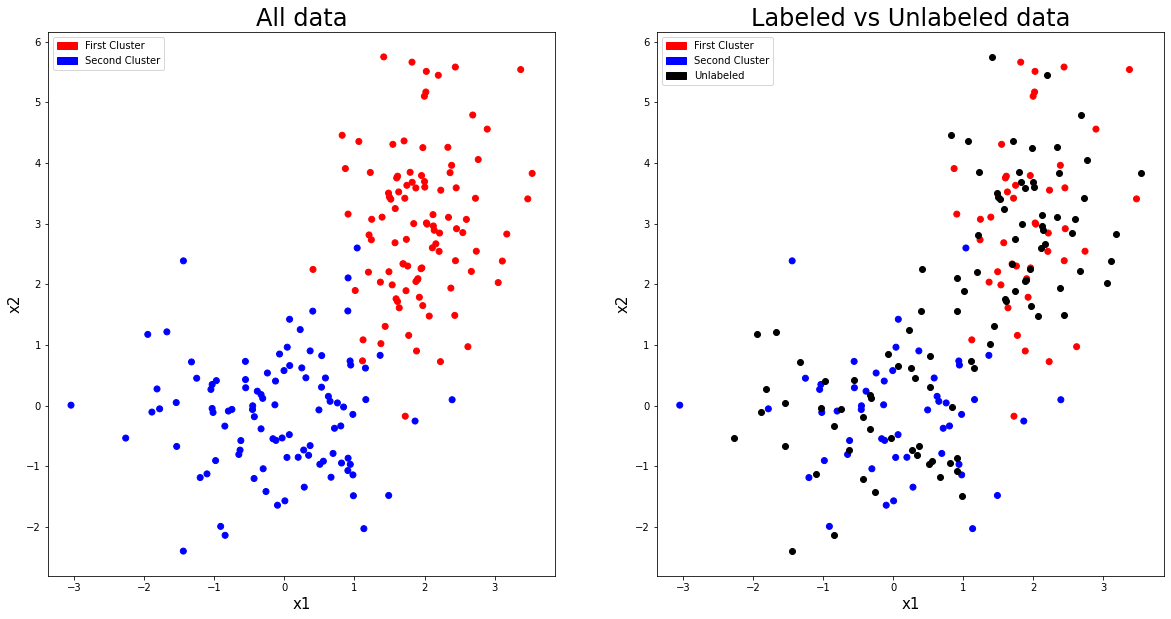

In [4]:
# Data visualization
data = {'x1 labeled': X_labeled[:,0], 'x2 labeled': X_labeled[:,1],
        'x1 unlabeled': X_unlabeled[:,0], 'x2 unlabeled': X_unlabeled[:,1],
        'y labeled': y_labeled, 'y unlabeled': y_unlabeled}
label = {'x1': 'x1', 'x2': 'x2', 'class': ('First Cluster','Second Cluster')}
plot_data(data, label)

In [5]:
# Computing weight matrix
W = distance_matrix(X_labeled,X_unlabeled)
W = 1/(W**2+1) #Converting the distance matrix into a similarity (weight) matrix with values in [0,1]
W = normalize_weight_matrix(W,y_labeled,1)

Gradient Descent

In [6]:
alpha = 1e-5
maxIter = 5000

In [7]:
alpha = 1e-5 #the stepsize 1/(N)**3 seems to be a good enough euristic
(y,y_list_GD,time_list_GD) = gradient_descent(W,y_labeled,np.zeros([N-known_variables,1]), alpha=alpha, maxIter=maxIter, armijo = False)

In [8]:
cost_list_GD = [cost_function(y_unlabeled, y_labeled, W) for y_unlabeled in y_list_GD]

BCGD randomized

In [9]:
#Method Parameters
block_length = 1
alpha = 1e-5
n_block = int(W.shape[0]/block_length)
maxIter = maxIter*n_block

In [10]:
# Optimize with 'BCGD randomized'
(y,y_list_random,time_list_BCGD_random) = bcgd_randomized(W,y_labeled,np.zeros([N-known_variables,1]), alpha=alpha, maxIter=maxIter, block_length=block_length)

In [11]:
time_list_BCGD_random = [t for idx, t in enumerate(time_list_BCGD_random) if (idx % n_block) == 0]
y_list_random = [y for idx, y in enumerate(y_list_random) if (idx % n_block) == 0]
cost_list_BCGD_random = [cost_function(y_unlabeled, y_labeled, W) for y_unlabeled in y_list_random]

BCGD cyclic

In [12]:
#Method Parameters
block_length = 1
alpha = 1e-5
maxIter = 5000

In [13]:
# Optimize with 'BCGD cyclic'
(y,y_list_BCGD_cyclic,time_list_BCGD_cyclic) = bcgd_cyclic(W,y_labeled,np.zeros([N-known_variables,1]), alpha=alpha, maxIter=maxIter, block_length=block_length)

In [14]:
cost_list_BCGD_cyclic = [cost_function(y_unlabeled, y_labeled, W) for y_unlabeled in y_list_BCGD_cyclic]

Algorithm and Model Performance

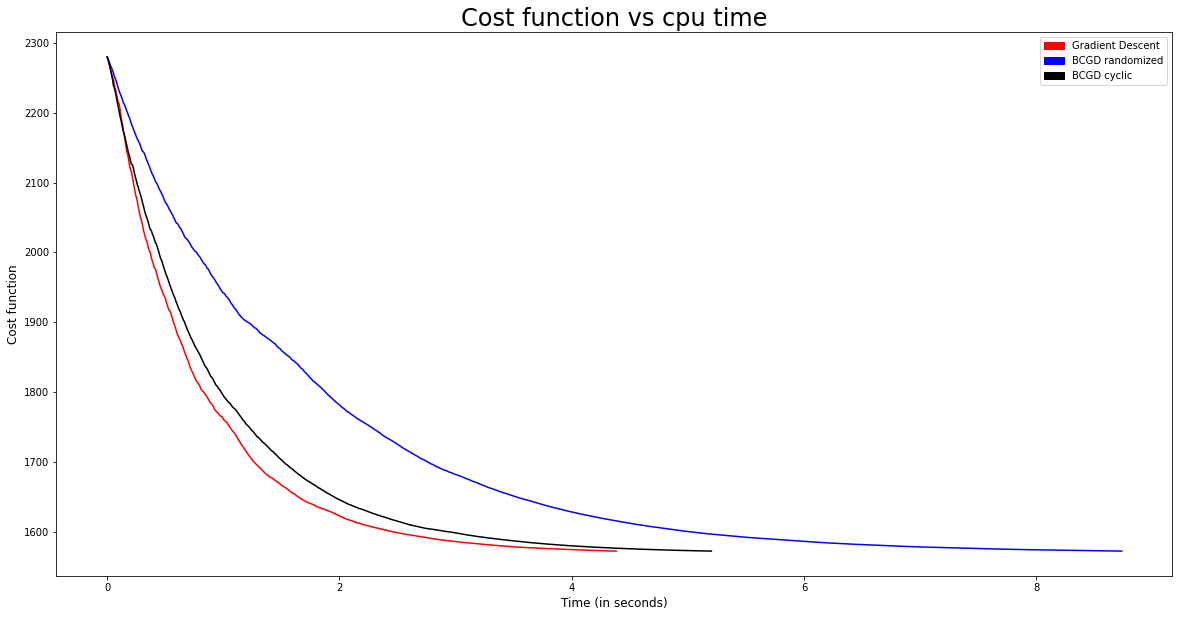

In [15]:
# Plot loss vs CPU time
time_list = [time_list_GD, time_list_BCGD_random, time_list_BCGD_cyclic]
loss_list = [cost_list_GD, cost_list_BCGD_random, cost_list_BCGD_cyclic]
plot_loss(time_list, loss_list)

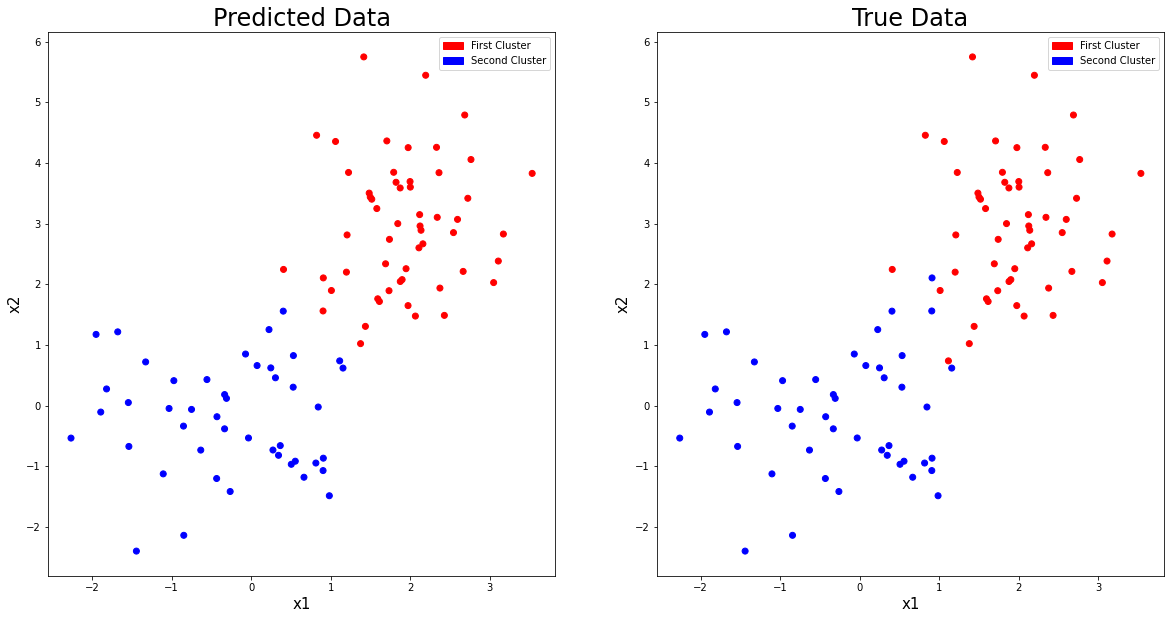

In [16]:
y_best = np.sign(y_list_GD[-1])
plot_performace(y_best, label, data, "Predicted Data")